### Example of Symbolic Regression to estimate thermal correction equation for UAS flights

Data generated by Moises Duran, TREX project.

Utah State University, 2025

File 'example_drone_thermal_camera_correction.csv' contains as potential predictors
```bash
- UAS tarp temp, air temp, RH, VPD and atmospheric pressure as predictors
- predictants (IRT) temperature in the last column.
```

### Instructions
- if not, create a anaconda environment, e.g. 
```bash
conda create -n pysr
```
- once completed the step above in the pysr environment install these modules:
```bash
conda install pysr
conda install matplotlib
pip install skillmetrics
```
- final step, in the activated environment and pass this command:
```bash
- python -c "import pysr
```
- last commands will install julia libraries, necessary to run the notebook.

### Running PySR 

Julia and Julia dependencies are installed at first import:

In [44]:
import pysr

Now, let's import everything else as well as the PySRRegressor:


In [45]:
import warnings
warnings.filterwarnings('ignore')

import sympy
import numpy as np
import pandas as pd
import skill_metrics as sm
import mpl_scatter_density # adds projection='scatter_density'

from pysr import PySRRegressor
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

### Set up PySR run:


using Moises' data

In [46]:
from pathlib import Path
import os

# Find the CSV file in the current directory or parent directories
csv_filename = 'example_drone_thermal_camera_correction.csv'
current_dir = Path.cwd()
current_dir

WindowsPath('d:/Github/PySR/examples')

In [47]:
from pathlib import Path
import os

# Check if file exists in current directory
if (current_dir / csv_filename).exists():
    csv_path = current_dir / csv_filename

print(f"Loading data from: {csv_path}")
df = pd.read_csv(csv_path)

# print(df.head())
X = df.iloc[:,0:-2]
y = df.iloc[:,-1]
print(y.head())

Loading data from: d:\Github\PySR\examples\example_drone_thermal_camera_correction.csv
0    39.5644
1    41.1856
2    39.1644
3    40.3947
4    40.7071
Name: IRT, dtype: float64


key pySR parameters to be changed:

In [48]:
niterations = 100  # for short runs, set this to a 100, for longer runs, set this to 10 million
timeout_in_seconds = 3600*2  # this line will make the code stop after 2 hours, change it as desired.
elementwise_loss = "L2DistLoss()"  #  (mean square) can be changed to "L1DistLoss()" for mean absolute error, see link at the end for more options

binary_operators = ["+", "*","-","/","^"] # these are the default binary operators (use these for basic equations)
# binary_operators = ["+", "*","-","/","^","ND(x,y) = ((x-y)/(x+y))", "SR(x,y)=x/y"]  # activate this line to use simple ratio and normalized diference functions (comment the repvious line)
unary_operators = ["sqrt", "exp", "log", "inv(x)=1/x"]  # other basic operators can be added here
extra_sympy_mappings = {"inv": lambda x: 1 / x,"ND": lambda x, y: ((x- y)/(x+y)),"SR": lambda x, y: x/y}  # here the format of the sought expressions are defined

The default parameters will help speed up code and ensure repeteability of run

In [49]:
default_pysr_params = dict(
    model_selection="best", #"score", "best", see documentation for more options
    random_state=0, # seed number to ensure reproducible results across different runs
    deterministic=True, #   to ensure reproducible results across different runs
    parallelism="serial", # to ensure reproducible results across different runs
    maxsize=50, # maximum complexity of the equations, increase to 100 for more complex equations, reduce to 20 for less complex equations   
    # select_k_features=10, # to automatically select few predictors (using random forest) from set of predictors, activate/deactive as you wish
    # denoise=True, # to remove scattering on y, activate/deactivate as you wish
    verbosity =0,   # 0 for no output, 1 for some output
    elementwise_loss= elementwise_loss,  #  (mean square) can be changed to "L1DistLoss()" for mean absolute error, see link at the end for more options
    )

In [50]:
# Learn equations
model = PySRRegressor(
    niterations=niterations,  # for short runs, set this to a 100, for longer runs, set this to 10 million
    timeout_in_seconds=timeout_in_seconds,  # this line will make the code stop after 2 hours
    binary_operators=binary_operators, # activate this line to use simple ratio and normalized diference functions (comment the repvious line)
    unary_operators=unary_operators, # other basic operators can be added here
    extra_sympy_mappings=extra_sympy_mappings, # here the format of the sought expressions are defined
    turbo=True, # set to True to speed up the code 
    **default_pysr_params,
)

model.fit(X, y)


PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                               TARP   
	1         0.410053                                   TARP ^ 1.0366857   
	2         0.039698                     (TARP ^ 1.1962142) / 1.8185421   
	3         0.094178                     (TARP ^ 1.0612687) - sqrt(VPD)   
	4         0.017029            (TARP ^ 1.0606134) - (VPD * 0.20210852)   
	5         0.039059    (Tair * (-6.9630685 / RH)) + (TARP ^ 1.0658666)   
	6         0.009347  (Tair * (-6.393882 / RH)) + ((TARP + -1.335057...   
	7         0.004597  (TARP ^ 1.0714687) - ((Tair * (sqrt(Tair) / RH...   
	8         0.005313  (TARP ^ 1.0778253) - (log(TARP) + (sqrt(Tair) ...   
	9         0.006153  (TARP ^ 1.0778253) - (((1.811961 + (sqrt(Tair)...   
	10        0.001103  ((TARP - 3.3159418) - ((((Tair / RH) * Tair) *...   
	11        0.000043  ((TARP - 3.329661) - ((Tair / ((RH - 0.6476207...   
	12        0.011063  (((log(TARP) * -1.4957285) + TARP) - ((((Tair ...   
	13        0.027784  ((TARP - 3.6615753) - (((((Tair * Tair) * 0.78...   
	14        0.005893  (((((log(RH) / (Tair - 16.752554)) + 6.66387) ...   
	15        0.000003  (((-0.10294175 - Tair) / RH) * (6.66387 + (log...   
	16  >>>>  0.056132  (TARP / 0.71433544) + ((-2.19707 * ((((VPD ^ -...   
	17        0.023220  (((((Tair ^ -0.8014521) / (Tair - (sqrt(Tair) ...   
	18        0.033409  (((VPD / ((Tair * sqrt(VPD / 2.4826467)) - exp...   
	19        0.000616  ((((VPD / ((Tair * sqrt(VPD / 2.4826467)) - ex...   
	20        0.000807  (inv(0.47229826) + (((VPD / ((sqrt(VPD / 2.482...   
	21        0.022679  ((VPD / ((sqrt((RH / 2.3604157) / 2.531071) * ...   
	22        0.001663  (((Tair / (-0.9622278 - (RH - (sqrt(exp(Tair))...   
	23        0.013126  (((log((TARP - 0.25898033) + Tair) * -3.036292...   
	24        0.005327  (3.2236624 / ((Tair - 0.2475541) - exp(VPD / s...   
	
	         loss  complexity  
	0   55.320374           1  
	1   24.362276           3  
	2   22.502817           5  
	3   20.480276           6  
	4   20.134462           7  
	5   18.621480           9  
	6   18.276608          11  
	7   18.192776          12  
	8   18.096373          13  
	9   17.875051          15  
	10  17.835667          17  
	11  17.834130          19  
	12  17.637915          20  
	13  17.154602          21  
	14  16.953588          23  
	15  16.953484          25  
	16  15.153163          27  
	17  14.465539          29  
	18  13.530575          31  
	19  13.513920          33  
	20  13.503016          34  
	21  13.200224          35  
	22  13.004138          44  
	23  12.338984          48  
	24  12.208225          50  
]

We can print the model pareto curve, which will showcase the trend of discovered solutions:

In [51]:
best_score=model.get_best().score

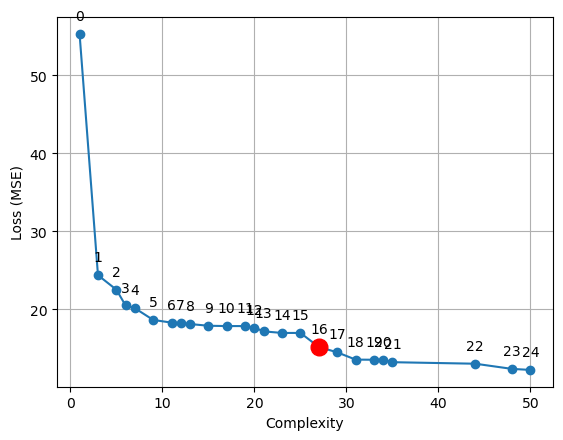

In [52]:
# best scoring equation (not the one with the lowest loss nor the one with the lowest complexity, but the one that optimally balances the two)
scores = model.equations_.score
# get the index of the first max
# max_index = scores.idxmax(axis=0)
max_index = scores == best_score
max_index


pareto =model.equations_.iloc[:, [0, 1]] # Print the equations found
# pareto
plt.plot(pareto.complexity,pareto.loss,'-o')
plt.plot(pareto.complexity[max_index],pareto.loss[max_index],'ro',markersize=12)
plt.grid(True)
plt.xlabel("Complexity")
plt.ylabel("Loss (MSE)")



ii=0
# zip joins x and y coordinates in pairs
for p,q, in zip(pareto.complexity,pareto.loss):

    label = "{:.0f}".format(ii)

    plt.annotate(label, # this is the text
                 (p,q), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    ii=ii+1
plt.show()

We can also view the SymPy format of the equation of our interest:

In [53]:
unique_max_index = max_index[max_index].index.tolist()
model.sympy(unique_max_index[0])  # get the selected equation in sympy format

1.39990254438447*TARP - 1.5195616*log(TARP) - 2.19707*Tair*(1/(VPD**0.84960043*(-sqrt(Tair) + Tair - 21.26186)) + 3.0733626)/RH

We can also view the form of any other expression in the list, using the index of it in `model.equations_`.

In [54]:
found_equations =model.equations_.iloc[:, [1,2]]  # print all the equations found
# pd.set_option('display.max_colwidth',200)  
# display(found_equations)

# Apply a color ramp to the 'Score' column
styled_df = found_equations.style.background_gradient(
    subset=['loss'],  # Column to apply gradient
    cmap='jet'      # Color map matplotlib colormap name
)

# Display in Jupyter Notebook
styled_df

,loss,equation
0,55.320374,TARP
1,24.362276,TARP ^ 1.0366857
2,22.502817,(TARP ^ 1.1962142) / 1.8185421
3,20.480276,(TARP ^ 1.0612687) - sqrt(VPD)
4,20.134462,(TARP ^ 1.0606134) - (VPD * 0.20210852)
5,18.621480,(Tair * (-6.9630685 / RH)) + (TARP ^ 1.0658666)
6,18.276608,(Tair * (-6.393882 / RH)) + ((TARP + -1.3350577) ^ 1.073179)
7,18.192776,(TARP ^ 1.0714687) - ((Tair * (sqrt(Tair) / RH)) + 2.270166)
8,18.096373,(TARP ^ 1.0778253) - (log(TARP) + (sqrt(Tair) * (Tair / RH)))
9,17.875051,(TARP ^ 1.0778253) - (((1.811961 + (sqrt(Tair) * Tair)) / RH) + log(TARP))


## Output

Plotting the first solutions

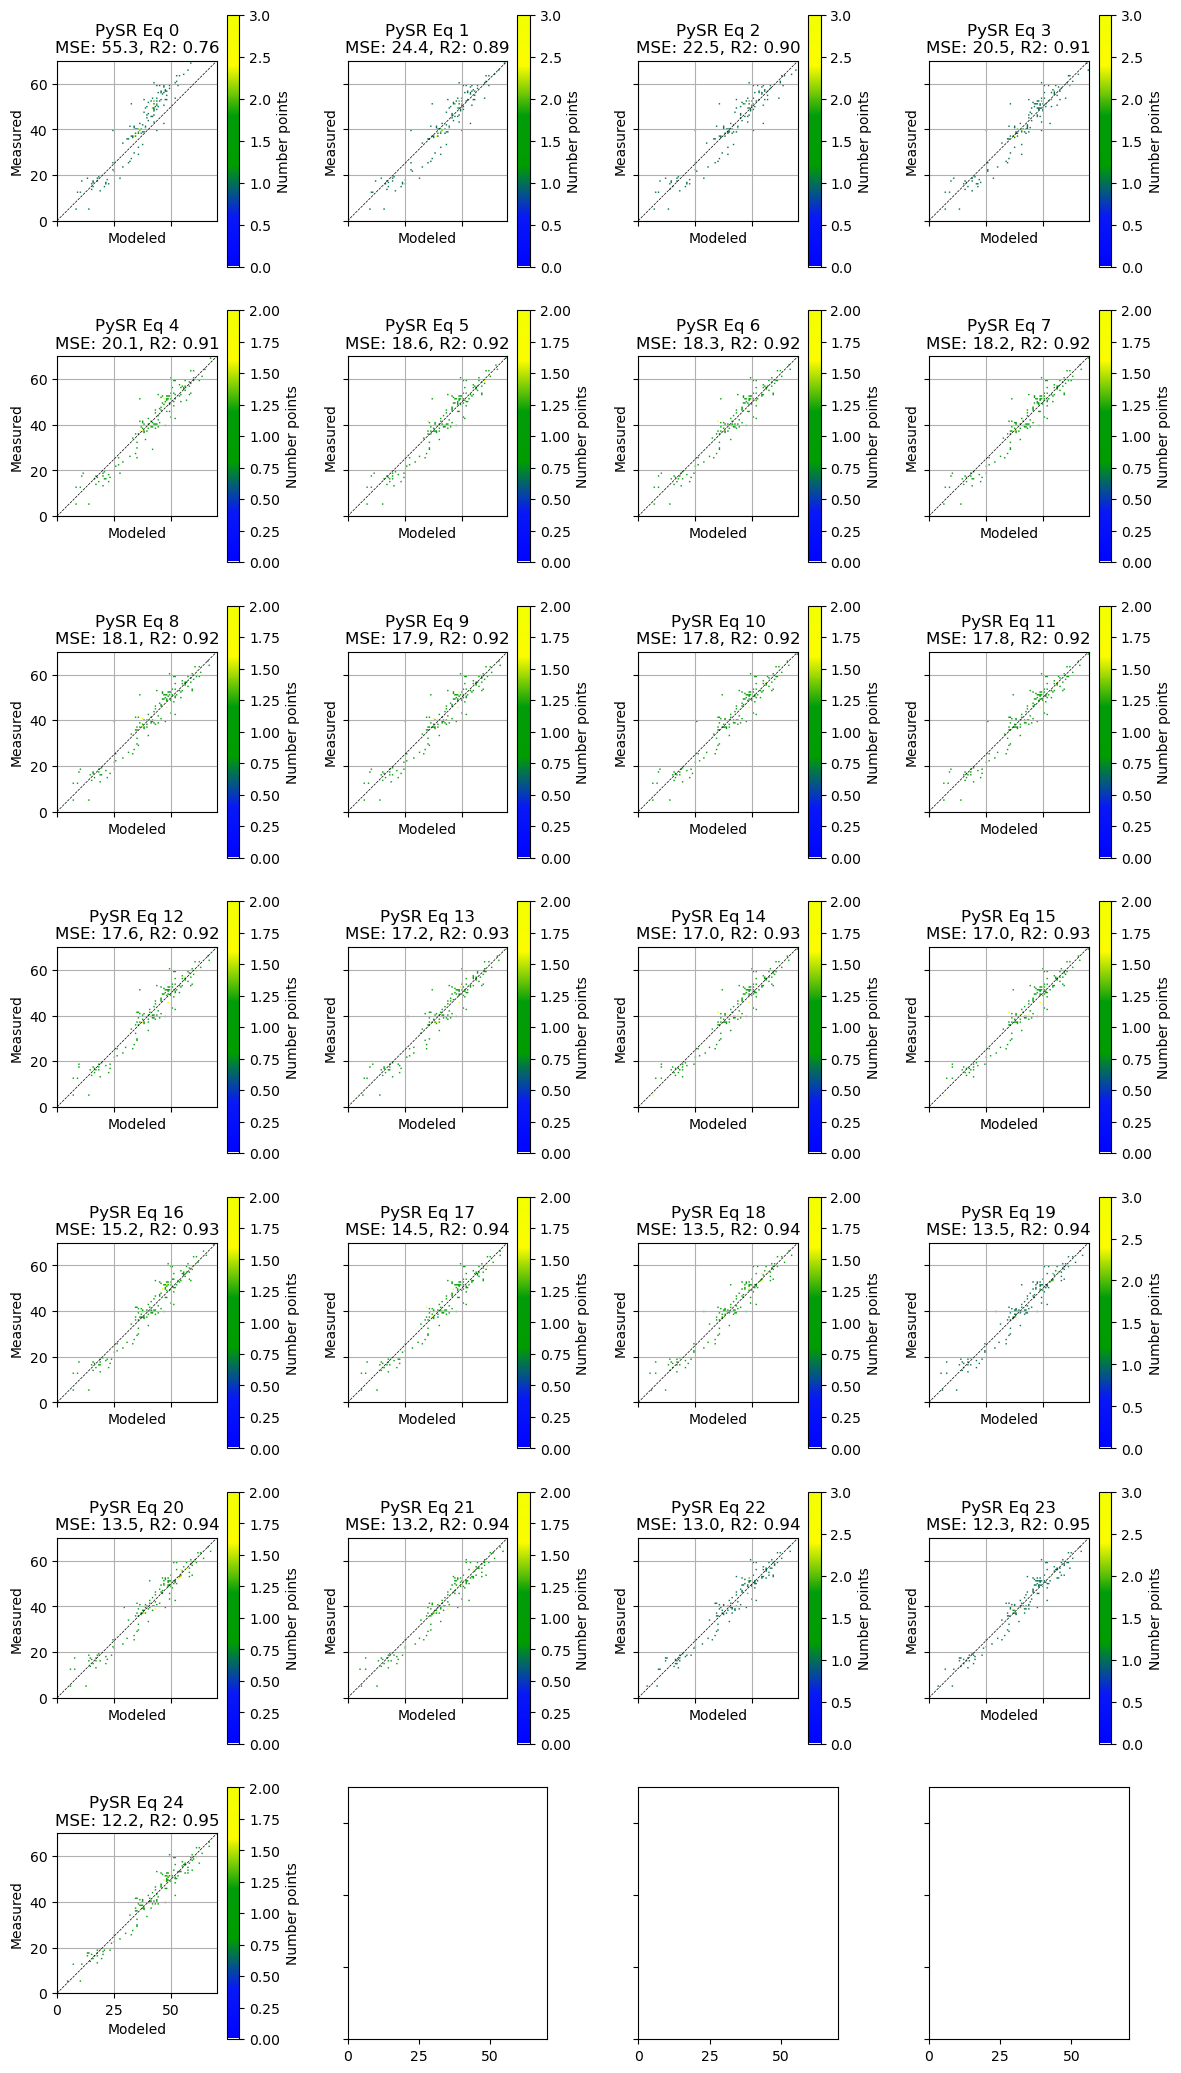

In [58]:
# "Viridis-like" colormap with white background
white_viridis = LinearSegmentedColormap.from_list('white_viridis', [
    (0, '#ffffff'),
    (1e-20, "#0004FF"),
    (0.2, "#0818F6"),
    (0.4, "#009d00"),
    (0.6, "#009d0a"),
    (0.8, "#fcfc01"),
    (1, "#f2ff00"),
], N=256)

num_eq = len(model.equations_)

fig_rows = int(np.ceil(num_eq / 4))
fig_cols = 4

fig, axes = plt.subplots(fig_rows, fig_cols, figsize=(3*fig_cols, 3*fig_rows),sharey=True, sharex=True,subplot_kw=dict(projection="scatter_density"))

it = np.linspace(0,num_eq-1,num_eq, dtype=int)  # Ensure indices are integers

# Iterate over the subplots and data
for ax, i in zip(axes.flatten(), it):  # Flatten axes for proper iteration
    ypredict_simpler = model.predict(X, index=i)  # Use integer index
    # ypredict_simpler = pd.Series(np.asarray(ypredict_simpler).ravel(), index=y.index)

    density=ax.scatter_density(ypredict_simpler, y, cmap=white_viridis)

    # ax.plot(ypredict_simpler, y,'.')

    ax.grid(True)
    ax.set_xlabel("Modeled")
    ax.set_ylabel("Measured")
    ax.plot( [0,70], [0,70], linestyle='--', color='k', linewidth=0.5 )
    fig.colorbar(density, label='Number points', ax=ax)

    ax.set_aspect('equal')
    ax.set_xlim(0, 70)
    ax.set_ylim(0, 70)
    mse = mean_squared_error(ypredict_simpler, y)
    r2 = r2_score(y, ypredict_simpler)
    ax.set_title('PySR Eq ' + str(i) + f"\nMSE: {mse:.1f}, R2: {r2:.2f}")
    ax.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

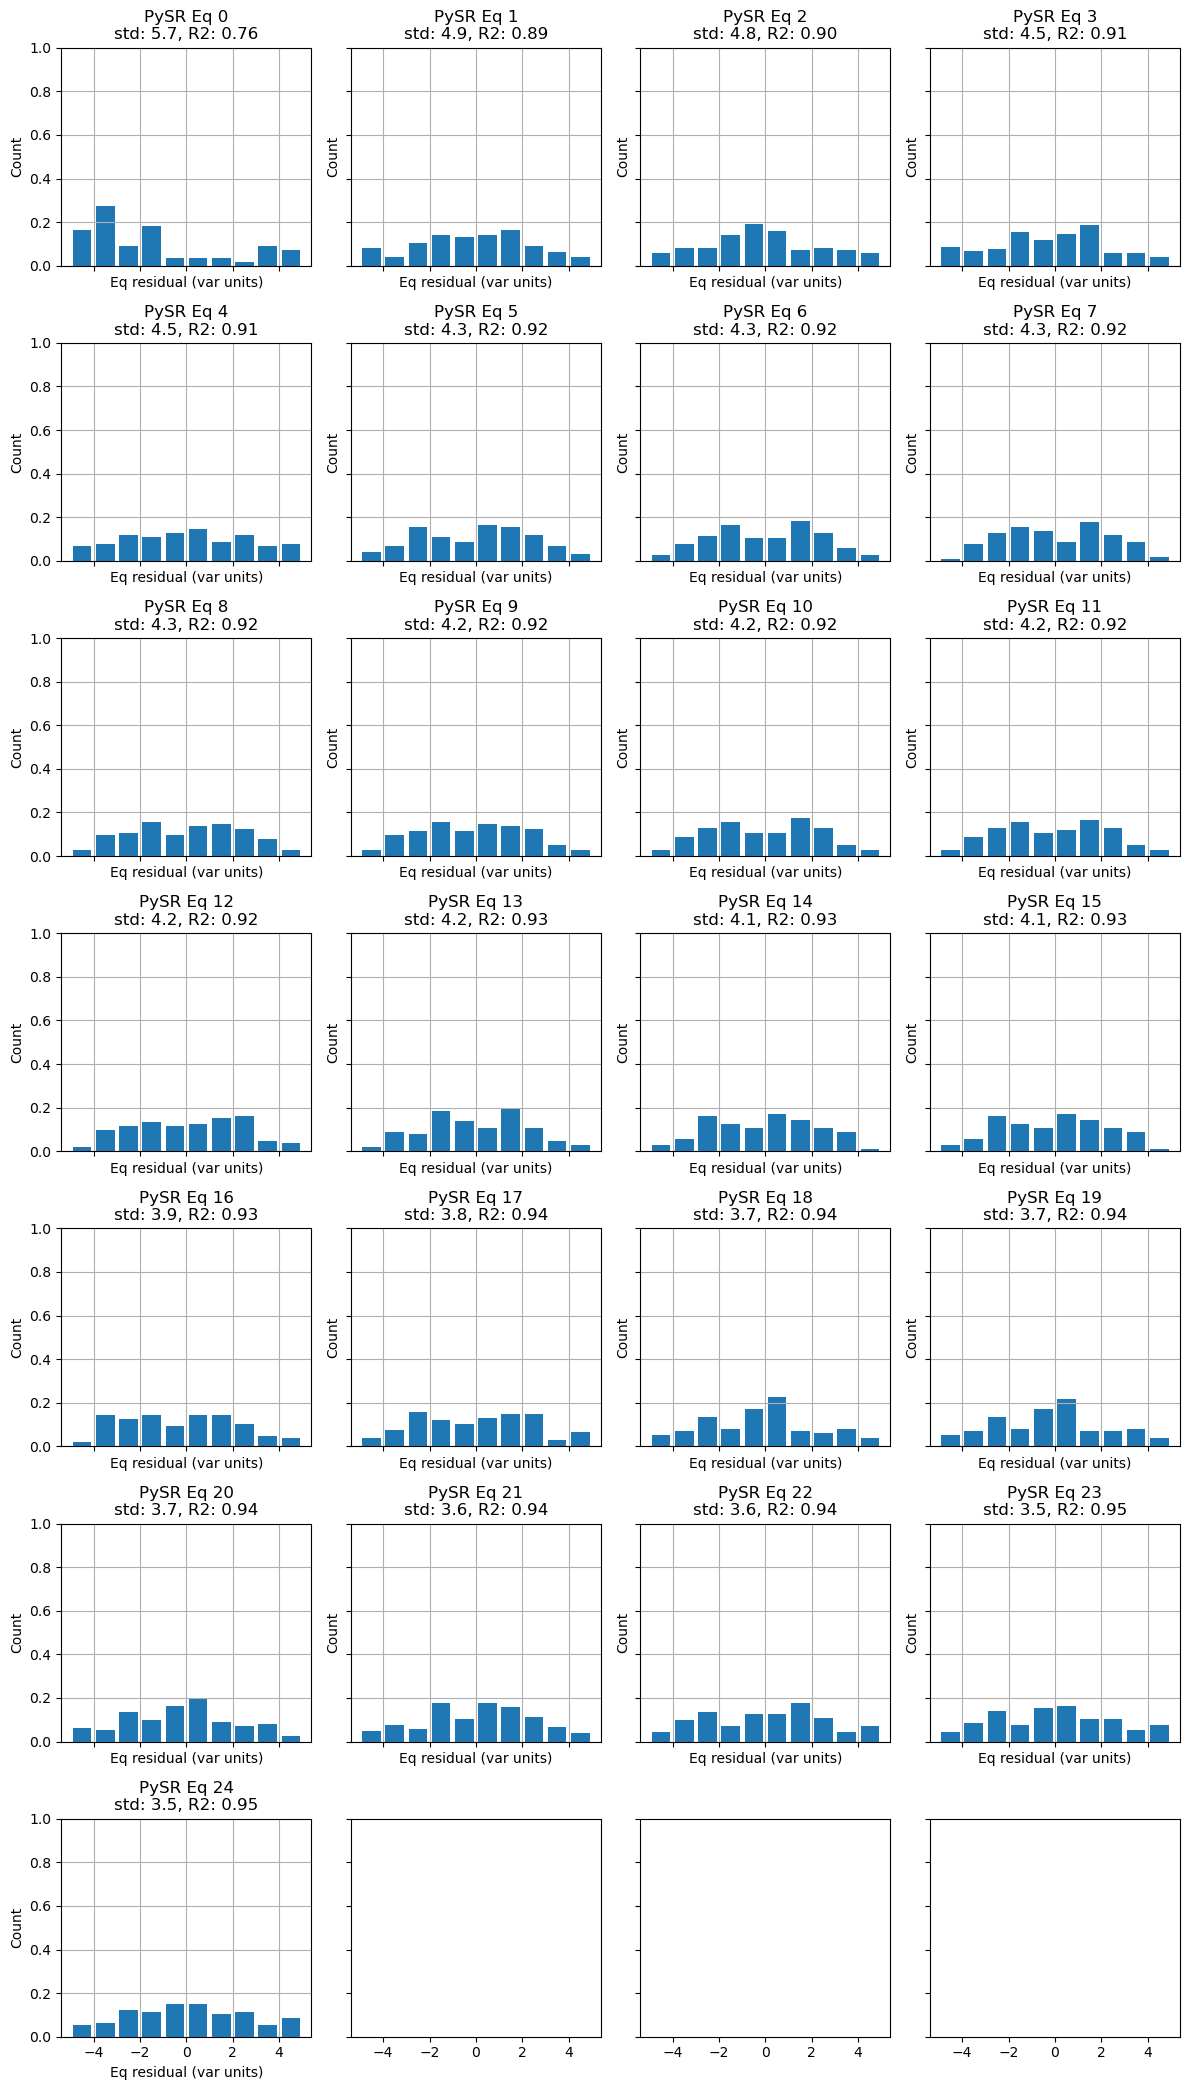

In [60]:
fig, axes = plt.subplots(fig_rows, fig_cols, figsize=(3*fig_cols, 3*fig_rows),sharey=True, sharex=True)

# Define bin interval and create bin edges
bin_interval = 1.0  # Adjust this value to change bin width
bins = np.arange(-5, 5 + bin_interval, bin_interval)

# Iterate over the subplots and data
for ax, i in zip(axes.flatten(), it):  # Flatten axes for proper iteration
    ypredict_simpler = model.predict(X, index=i)  # Use integer index
    ax.hist(ypredict_simpler- y, bins=bins, density=True, rwidth=0.8)
    ax.grid(True)
    ax.set_xlabel("Eq residual (var units)")
    ax.set_ylabel("Count")
    # ax.plot( [0,70], [0,70], linestyle='--', color='k' )
    ax.set_ylim(0, 1)

    N = len(y)
    mean = np.mean(ypredict_simpler - y)
    ddof = 1  # Use sample standard deviation
    d2 = abs(ypredict_simpler- y - mean)**2  # abs is for complex `a`
    var = d2.sum() / (N - ddof)  # note use of `ddof`
    std = var**0.5
    r2 = r2_score(y, ypredict_simpler)
    ax.set_title('PySR Eq ' + str(i) + f"\nstd: {std:.1f}, R2: {r2:.2f}")
    ax.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

Create a Taylor diagram with labeled data points and modified axes

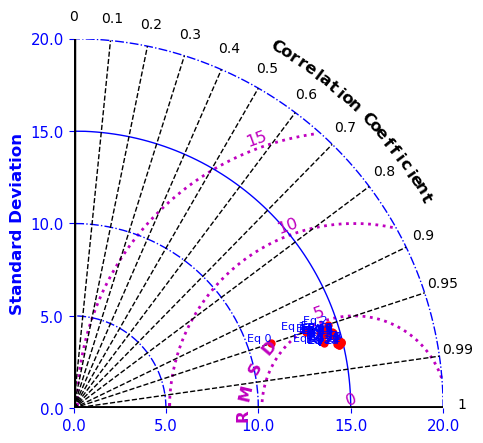

In [57]:
import numpy as np
import skill_metrics as sm
    
# number of equations found
n_e= len(found_equations)

it2 = np.linspace(0,n_e-1,n_e, dtype=int)  # Ensure indices are integers

# Prepare data for Taylor diagram
data = {}
# data=pd.DataFrame(data)

sdev = np.array([])
crmsd = np.array([])
ccoef = np.array([])

data['ref'] = y.values  # Store reference data in data dictionary
taylor_stats = sm.taylor_statistics(data['ref'],data['ref'])
sdev = np.append(sdev,[taylor_stats['sdev'][0]])
crmsd = np.append(crmsd,[taylor_stats['crmsd'][0]])
ccoef = np.append(ccoef,[taylor_stats['ccoef'][0]])

for i in it2:
    ypredict_simpler = model.predict(X, index=i)  # Use integer index
    data['pred'+str(i+1)] = ypredict_simpler  
    taylor_stats = sm.taylor_statistics(data['pred'+str(i+1)],data['ref'])
    sdev = np.append(sdev,[taylor_stats['sdev'][1]])
    crmsd = np.append(crmsd,[taylor_stats['crmsd'][1]])
    ccoef = np.append(ccoef,[taylor_stats['ccoef'][1]])
    
data = pd.DataFrame(data)
data

# Specify labels for points in a cell array (M1 for model prediction 1,
# etc.). Note that a label needs to be specified for the reference even
# though it is not used.
label = ['Reference'] + ['Eq ' + str(i) for i in it2]    

# Produce the Taylor diagram

#     Label the points and change the axis options for SDEV, CRMSD, and CCOEF.
intervalsCOR = np.concatenate((np.arange(0,1.0,0.2), 
                                   [0.9, 0.95, 0.99, 1]))
sm.taylor_diagram(sdev,crmsd,ccoef, markerLabel = label,
                      markerLabelColor = 'b', 
                      tickRMS= np.arange(0,20,5),
                      tickRMSangle = 110.0, 
                      colRMS = 'm', styleRMS = ':', widthRMS = 2.0,
                      tickSTD = np.arange(0,20,5), axismax = 20.0, 
                      colSTD = 'b', styleSTD = '-.', widthSTD = 1.0,
                      colCOR = 'k', styleCOR = '--', widthCOR = 1.0)
# plt.title('Taylor Diagram of Drone Thermal Camera Correction Models', fontsize=16)


From the three plots it is evident that Equations before #8 are not necesarily robust. Still Equation 3 is simple and the error histogram is narrow. 

# Other PySR Options

The full list of PySR parameters can be found here: https://ai.damtp.cam.ac.uk/pysr/api